## Project Overview
- The adssigned priject is to use the provided data set privided by a "Company" to forecast what the nex month sales will be. THe data provided is monthly data for your use. You will need to provide the  CF of the company this  report forecastig the next month prediction.
- Back test the model that you have created on past dat to test the model prediction as well. Determine if this is an accurate model to present to the CFO

### Project Approach
- Determine the test size for the data that. 
- Set the train and test size for the model
- Scale the data accordingly 
- Build the Model using the LSTM layer
- Forecast one month in to the future using the Model 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv("resources/RSCCASN.csv", parse_dates = True, index_col="DATE")

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


## initial Observation
- There is a pattern to the monthly sales for the company. 
- This could be seasonal or quaterly etc. we will let our model find the pattern in the sales

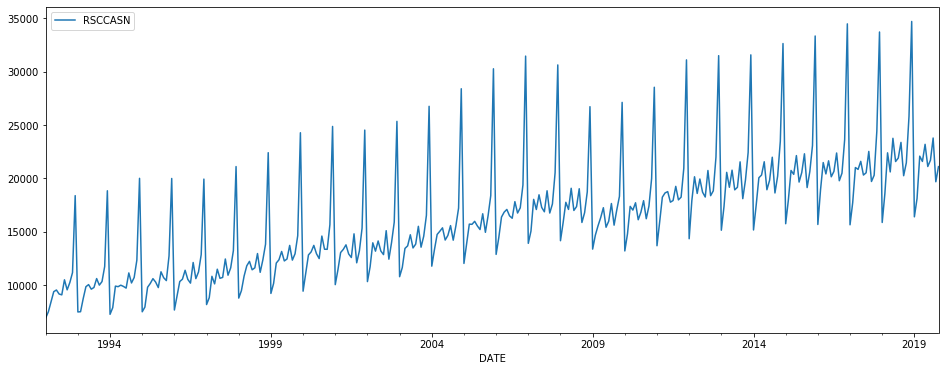

In [8]:
data.plot(figsize = (16,6))

## Data Prepration 
- There are 334 data points in the data set, meaning 334 months to consider 
- We may want to get a resonable about of data for the test set, say , 18 months(1.5 years)

In [36]:
test_size = 18

In [37]:
test_index = len(data) - test_size

### Test and Train Data Set 
- The test size should = the sample size above
- training will take place on the remaining data set

In [38]:
train = data.iloc[:test_index]

In [39]:
test = data.iloc[test_index:]

In [40]:
train.shape

(316, 1)

In [41]:
test.shape

(18, 1)

### Scaling the data
- Will scale the data to the appropriate range to consider the outliers and the standard deviation os the sales

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scalar = MinMaxScaler()

In [44]:
train_scaled = scalar.fit_transform(train)

In [45]:
test_scaled = scalar.transform(test)

### Times series Generator and Setting a Length
- Length will represent the number of months we want our model to train to predict
- though we are only forecasting one month out we wll set it to 3 month
- this will make the model train to predict 3 months for better accuracy

In [46]:
lengt = 3 

In [47]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [48]:
gen = TimeseriesGenerator(train_scaled,train_scaled, length=lengt, batch_size=1)

## Vaidation Gen
- used to provide the model validation data againt the training data
- Number of features will be the number of features we are aiming to predict which is 1

In [49]:
val_gen = TimeseriesGenerator(test_scaled,test_scaled, length=lengt, batch_size=1)

In [50]:
n_features = 1 

## Early Stopping
- Will use to prevent over training

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
stop = EarlyStopping(monitor="val_loss",mode = "min", patience=5)

### Model Creation

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [54]:
model = Sequential()
model.add(LSTM(units = 200, activation = "relu", input_shape = (lengt, n_features)))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam", metrics = ["accuracy"])

## Fitting Generators to model

In [55]:
model.fit_generator(generator=gen, validation_data=val_gen, epochs=20, callbacks=[stop])

Epoch 1/20
313/313 [==============================] - 46s 146ms/step - loss: 0.0284 - accuracy: 0.0000e+00 - val_loss: 0.0433 - val_accuracy: 0.0000e+00
Epoch 2/20
313/313 [==============================] - 44s 141ms/step - loss: 0.0247 - accuracy: 0.0032 - val_loss: 0.0280 - val_accuracy: 0.0000e+00
Epoch 3/20
313/313 [==============================] - 44s 140ms/step - loss: 0.0236 - accuracy: 0.0000e+00 - val_loss: 0.0381 - val_accuracy: 0.0000e+00
Epoch 4/20
313/313 [==============================] - 44s 141ms/step - loss: 0.0230 - accuracy: 0.0000e+00 - val_loss: 0.0345 - val_accuracy: 0.0000e+00
Epoch 5/20
313/313 [==============================] - 44s 141ms/step - loss: 0.0214 - accuracy: 0.0032 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 6/20
313/313 [==============================] - 44s 140ms/step - loss: 0.0186 - accuracy: 0.0032 - val_loss: 0.0307 - val_accuracy: 0.0000e+00
Epoch 7/20
313/313 [==============================] - 44s 141ms/step - loss: 0.0183 - accuracy

## Model Training Performance

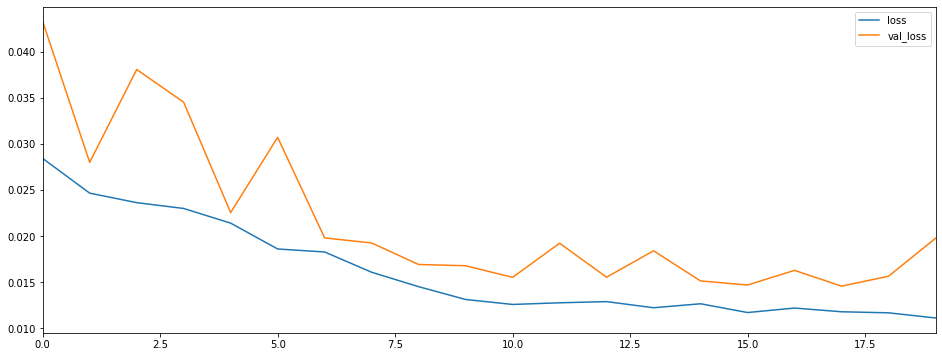

In [56]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot(figsize = (16,6))

In [96]:
#pd.DataFrame(model.history.history)[["loss", "val_loss"]].to_csv("resources/Model_history.csv")

### Predicitons
- We will use the model to predict the values for the length of the test values

In [57]:
test_predicitons = []
batch = train_scaled[-lengt:]
current_b = batch.reshape((1,lengt,n_features))
for x in range(len(test)):
    predictions = model.predict(current_b)[0]
    test_predicitons.append(predictions)
    current_b = np.append(current_b[:,1:,:], [[predictions]], axis=1)

### Our model is displaying scaled data
- we will need to in verse the scaling to fix this
- We will then match this up with the test data

In [59]:
true_test = scalar.inverse_transform(test_predicitons)

In [61]:
test["pred"] = true_test

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### First month out
- Model predicted what we see in the Pred col abd the real Value in the RSCCASN column. WE can see that the model was pretty accurate

In [66]:
test.head(1)

,RSCCASN,pred
DATE,,
2018-05-01,23764,23549.765107


### Test prediciton Summary 
- We can see that the model picked up the patters of the data with prediction. Though not extremely accurate througho ut. The model does predict the first item accurately which is what we want
- We can now forecast with this model since the first month forward was accurate

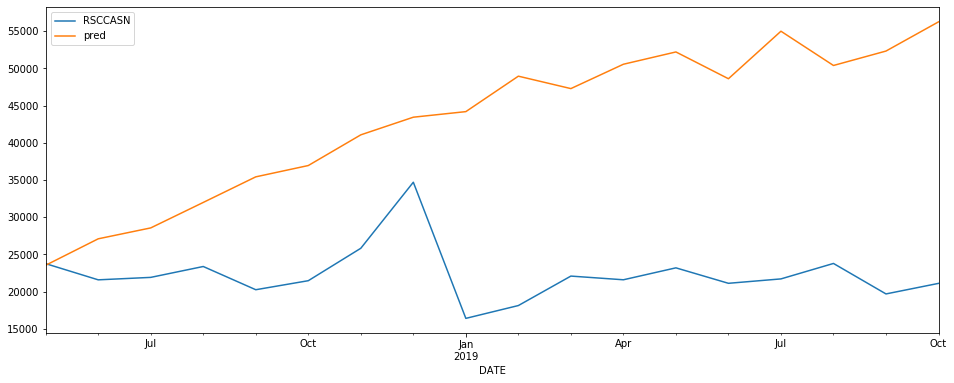

In [64]:
test.plot(figsize = (16,6))

### Forecasting
- we will use the data set to forecast 3 months into the future
- will need a scaled version of the full data set 
- since we are forecasting forward 3 months frm the ed of the data

In [95]:
#model.save("resources/sales_model.h5")

In [67]:
data_scalar = MinMaxScaler()

In [68]:
data_scaled = data_scalar.fit_transform(data)

In [71]:
forecast = []
periods = lengt
bb = data_scaled[-lengt:]
c_batch = bb.reshape(1,lengt, n_features)
for x in range(periods):
    pre = model.predict(c_batch)[0]
    forecast.append(pre)
    c_batch = np.append(c_batch[:,1:,:], [[pre]], axis=1)

In [ ]:
true_forecast = data_scalar.inverse_transform(forecast)

## Forecast Results 
- Model predicts that the next month sales will be approximately 24,543

In [74]:
true_forecast

array([[24543.27290487],
       [27367.01556349],
       [29476.35671186]])

## Time Series
- we will need a time seried for the forecast beginning from the next mont after the last in our data 
- Month after 2019-10-1, which will be 2019-11-1

In [80]:
data.tail()[-1:]

,RSCCASN
DATE,
2019-10-01,21113


In [82]:
dat_time_forecast = pd.date_range(start = "2019-11-1", periods=periods, freq="B")

In [86]:
forecast_df = pd.DataFrame(true_forecast, index=dat_time_forecast, columns=["Forecast"])

In [92]:
forecast_df

,Forecast
2019-11-01,24543.272905
2019-11-04,27367.015563
2019-11-05,29476.356712


(12892, 13003)

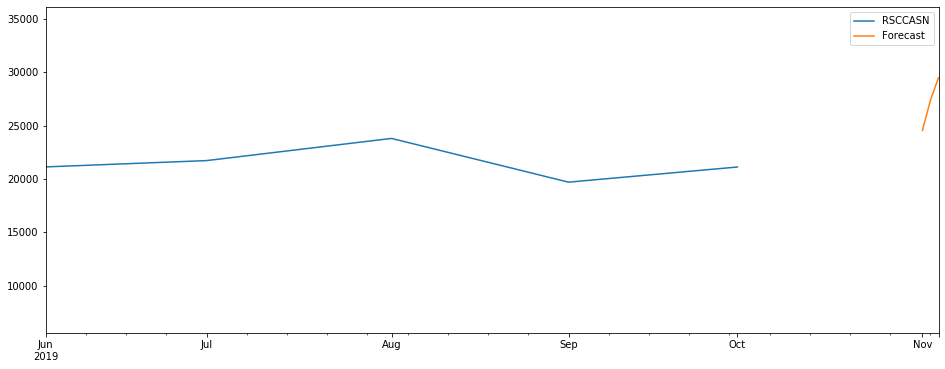

In [94]:
ax = data.plot(figsize = (16,6))
forecast_df.plot(ax = ax)
plt.xlim("2019-6-1", "2019-11-05")